# Introduction to Computer Vision (ECSE 415)
# Assignment 2: Image Stitching and Classification
### Question 1: Image Stitching
### Author: Antonios Valkanas

In [1]:
# Import useful libraries
import cv2, time
import numpy as np
from matplotlib import pyplot as plt

### 2.1 Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill.

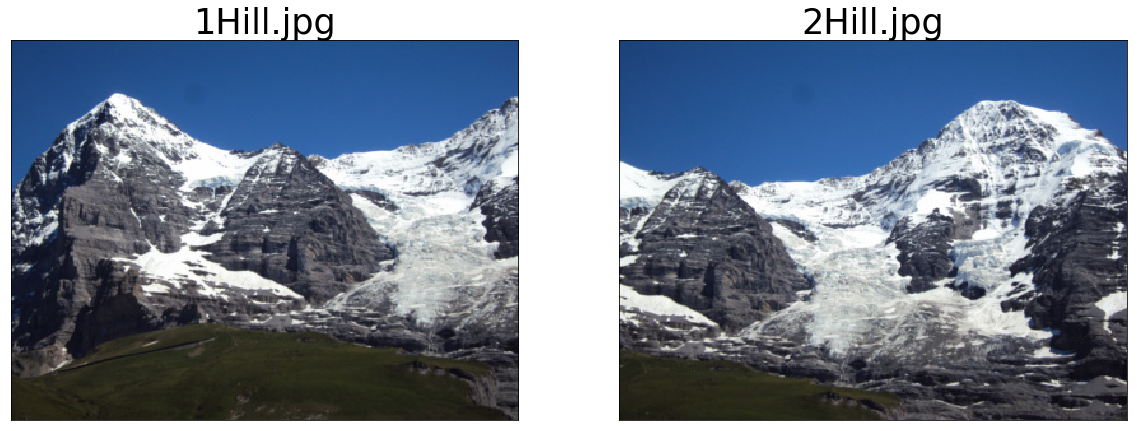

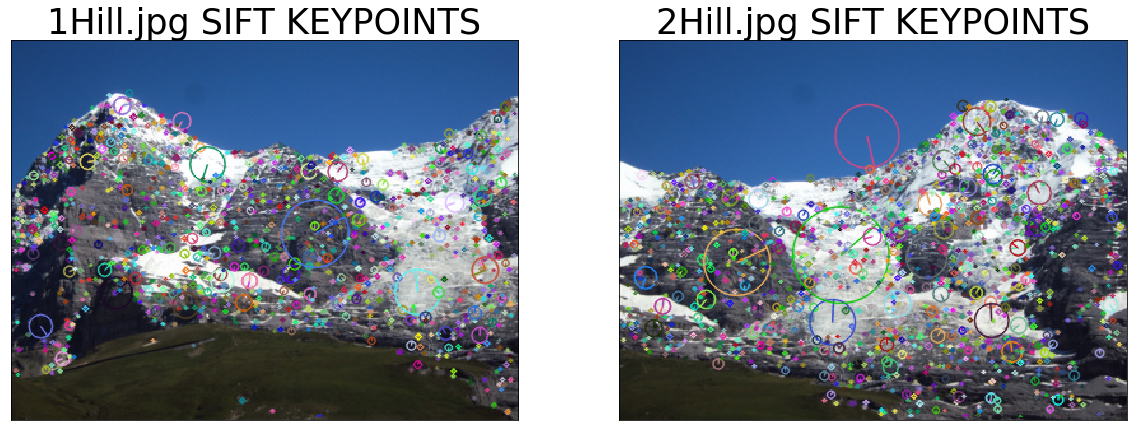

In [2]:
# Read images to stitch
imgl = cv2.imread('stitching_images/1Hill.jpg')[1:, 1:] # removes the border
imgr = cv2.imread('stitching_images/2Hill.jpg')[1:, 1:] # removes the border

imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

img1 = imgl.copy() # Copy to draw keypoints
img2 = imgr.copy() # Copy to draw keypoints

shifted = False # Boolean used such that when rerunning the Q2.3 cell the code does not fail.

# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_l, descriptors_l = sift_obj.detectAndCompute(imgl, None)
keypoints_r, descriptors_r = sift_obj.detectAndCompute(imgr, None)

# Draw the keypoints.  
cv2.drawKeypoints(img1, keypoints_l, img1, flags = 4)
cv2.drawKeypoints(img2, keypoints_r, img2, flags = 4)

# Display original imgaes along with keypoints.
# I set keypoints flag to 4 for rich keypoint drawing.
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(imgl)
plt.title("1Hill.jpg", fontsize = 35), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgr)
plt.title("2Hill.jpg", fontsize = 35), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(img1)
plt.title("1Hill.jpg SIFT KEYPOINTS", fontsize = 35), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img2)
plt.title("2Hill.jpg SIFT KEYPOINTS", fontsize = 35), plt.xticks([]), plt.yticks([])
plt.show()

### 2.2 Find matching keypoints in two images and display the 20 best pairs.

(Text(0.5,1,'Matched Keypoints'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

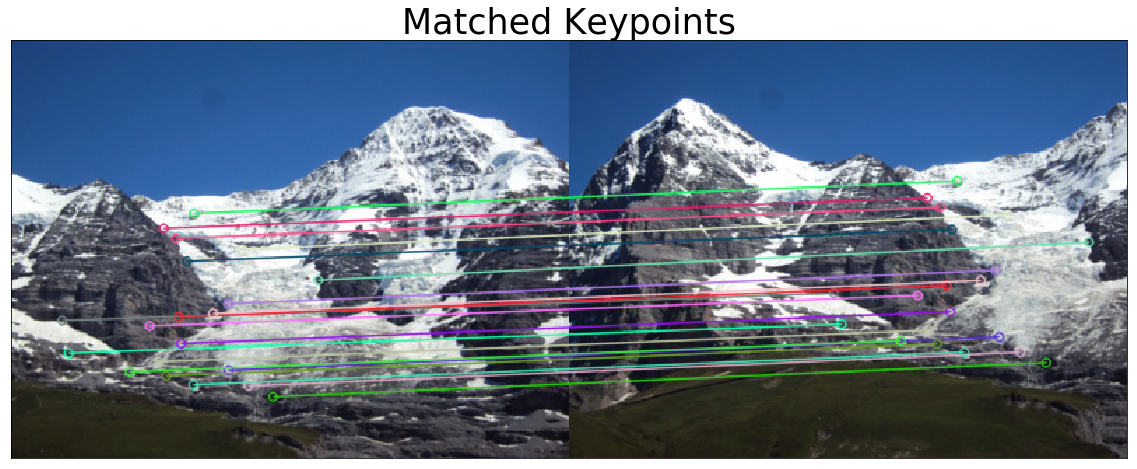

In [3]:
# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_r,descriptors_l)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch = cv2.drawMatches(imgr,keypoints_r,imgl,keypoints_l, matches[:20], imgr, flags=2)

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints_r[i].pt for (__, i) in GoodMatches])
mpl = np.float32([keypoints_l[i].pt for (i, __) in GoodMatches])

plt.figure(figsize=(20,20))
plt.imshow(imgmatch)
plt.title("Matched Keypoints", fontsize = 35), plt.xticks([]), plt.yticks([])

### 2.3 Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

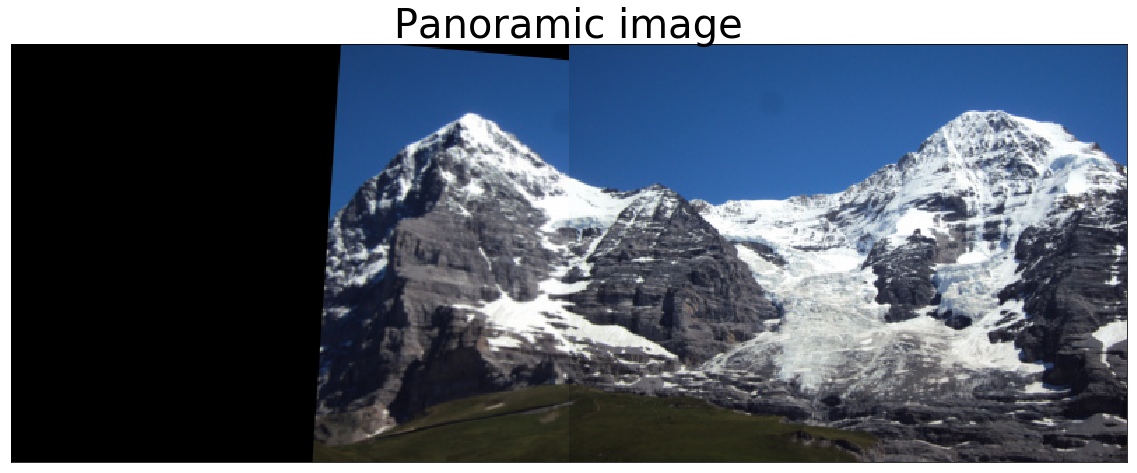

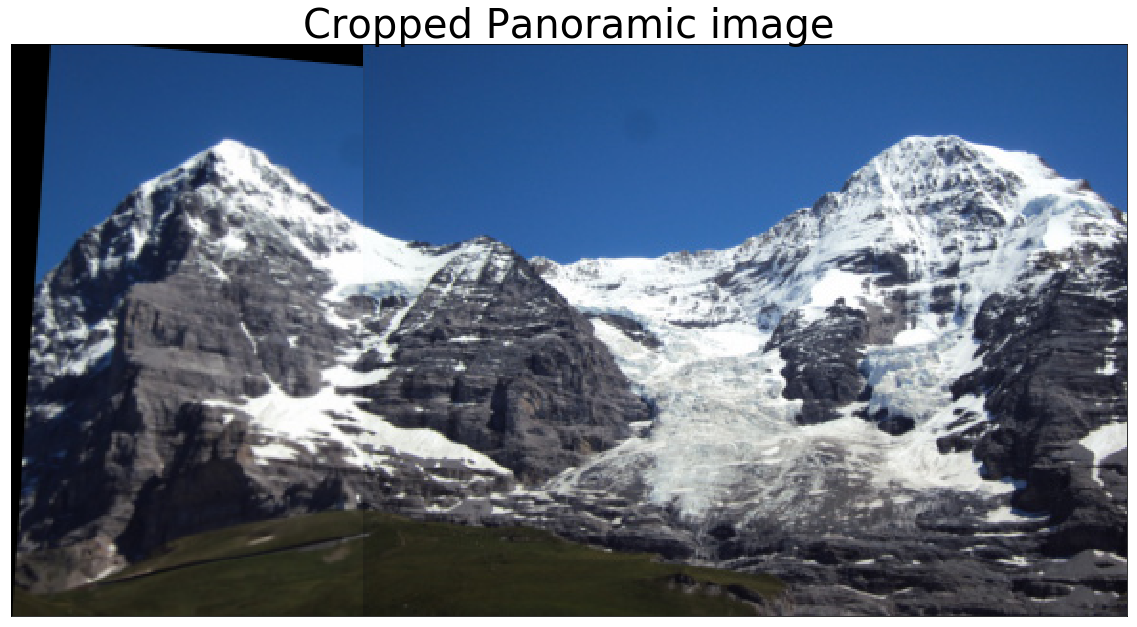

In [4]:
# Shift the points on the right image so that it can fit to the left one
if not shifted: # Boolean used such that when rerunning the cell the code does not fail.
    for i in range(len(mpr)):
        mpr[i][0] += imgr.shape[1]
    shifted = True
    
# Find the homography matrix and wrap image accordingly
H, __ = cv2.findHomography(mpl, mpr, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(imgl, H, (imgr.shape[1]+imgl.shape[1],imgr.shape[0]))
wimg_temp = wimg.copy()
wimg[:imgl.shape[0],imgl.shape[1]:,:] = imgr

# Helper method used to remove the black leftover pixels on the panoramic pic
def auto_crop(image, threshold=0):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #contours, h = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = image[y:y+h,x:x+w]
    return crop


plt.figure(figsize=(20,20))
plt.imshow(wimg)
plt.title("Panoramic image", fontsize = 40), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(auto_crop(wimg))
plt.title("Cropped Panoramic image", fontsize = 40), plt.xticks([]), plt.yticks([])
plt.show()

### 2.4 Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

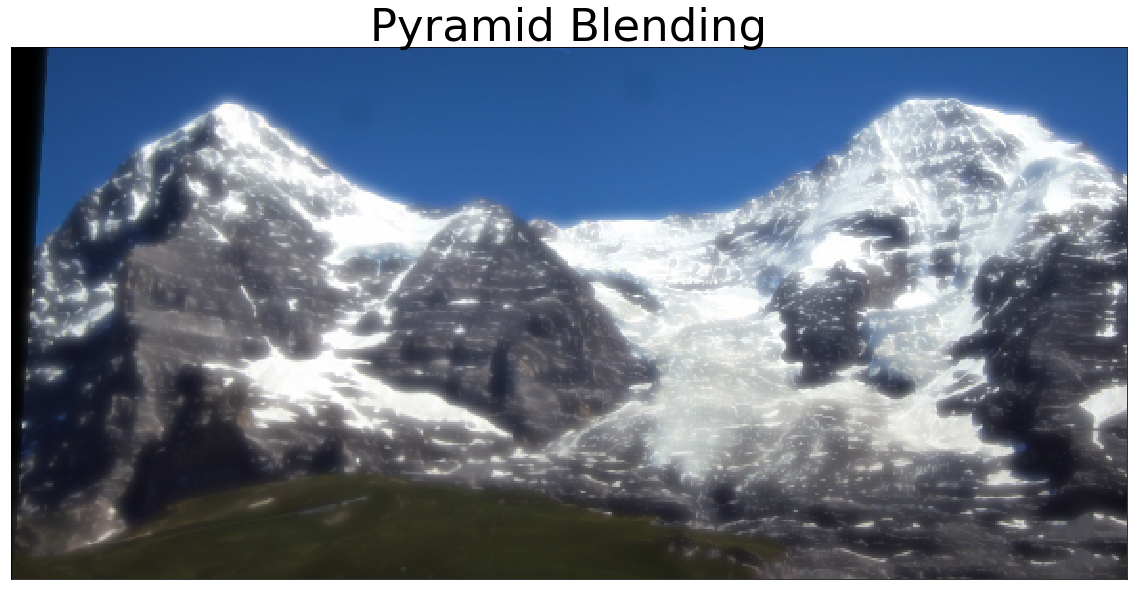

In [5]:
# Read ovewritten images again.
imgr = cv2.imread('stitching_images/2Hill.jpg')[1:, 1:] # removes the border
imgl = wimg_temp
# Add buffer pixels to right image to make it have equal size to the left one
imgr = cv2.copyMakeBorder(imgr, 0, 0, (-imgr.shape[1] + imgl.shape[1]) , 0, cv2.BORDER_CONSTANT,value=255)
imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)

#Determine Shape and create un-blended image before blending
imgl = imgl[21:, 215:]
imgr = imgr[21:, 215:]

# parameters
g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size

A = imgl.copy()
B = imgr.copy()

""" PYRAMID BLENDING """
row, col, dpt = A.shape
# generate Gaussian pyramid for imgA
G = A.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Gaussian pyramid for imgB
G = B.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((A.shape[1], A.shape[0]))
# create mask
mask[:, round(A.shape[1]/2):] = 1
# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)
# generate Gaussian pyramid
G = mask.copy()
GR = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)

# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i

    # Now blend
    lp = (1-GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1)) * la + \
         GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs, dstsize=(LP_mask[i].shape[1], LP_mask[i].shape[0]))  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask,  dstsize=(LP_mask[i].shape[1], LP_mask[i].shape[0]))  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image

# display results
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(rs, cv2.COLOR_RGB2BGR))
plt.title('Pyramid Blending', fontsize = 45), plt.xticks([]), plt.yticks([])
plt.show()

twelve_hill = rs

### 2.1.1 Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

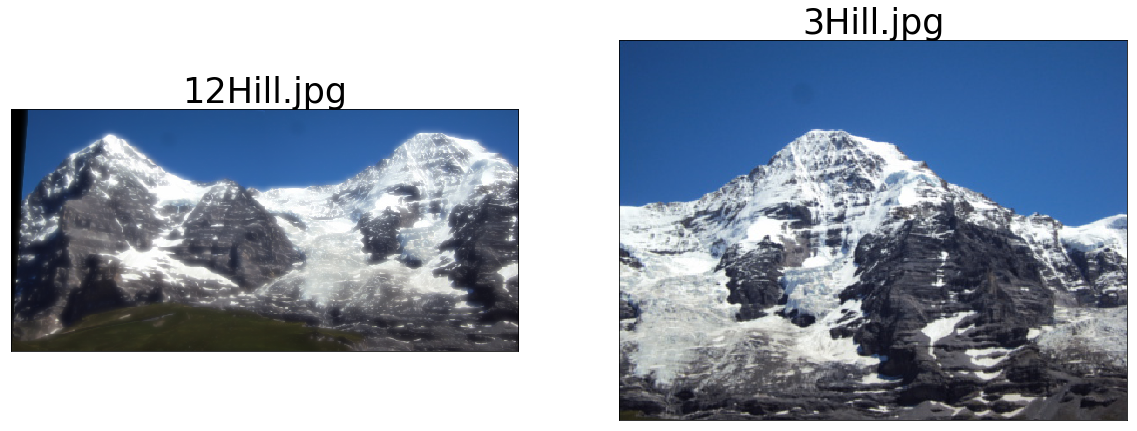

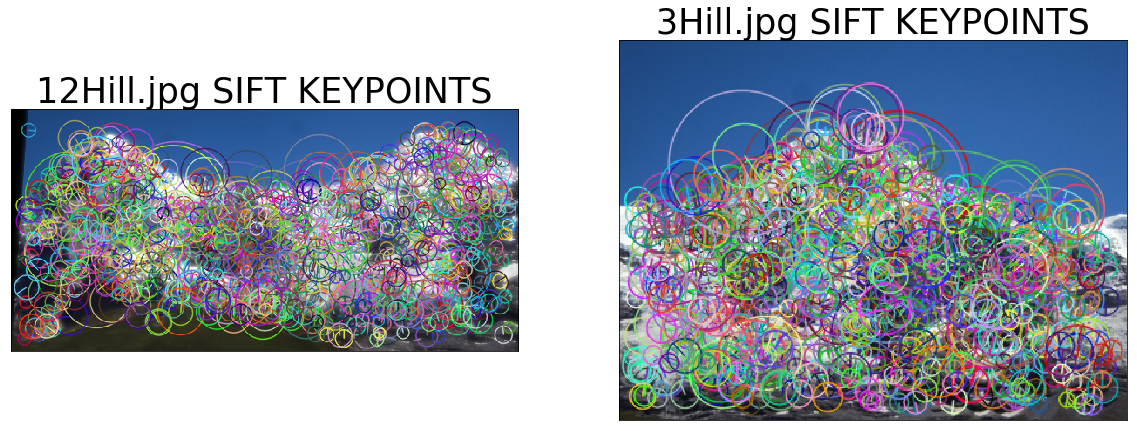

In [6]:
# Read images to stitch
imgl = twelve_hill # set left image to Hill 12
imgr = cv2.imread('stitching_images/3Hill.jpg')[1:, 1:] # removes the border

imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

img1 = imgl.copy() # Copy to draw keypoints
img2 = imgr.copy() # Copy to draw keypoints

shifted = False # Boolean used such that when rerunning the Q2.3 cell the code does not fail.

# Compute keypoints and descriptors
surf_obj = cv2.xfeatures2d.SURF_create()
keypoints_l, descriptors_l = surf_obj.detectAndCompute(imgl, None)
keypoints_r, descriptors_r = surf_obj.detectAndCompute(imgr, None)

# Draw the keypoints.  
cv2.drawKeypoints(img1, keypoints_l, img1, flags = 4)
cv2.drawKeypoints(img2, keypoints_r, img2, flags = 4)

# Display original imgaes along with keypoints.
# I set keypoints flag to 4 for rich keypoint drawing.
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(imgl)
plt.title("12Hill.jpg", fontsize = 35), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgr)
plt.title("3Hill.jpg", fontsize = 35), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(img1)
plt.title("12Hill.jpg SIFT KEYPOINTS", fontsize = 35), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img2)
plt.title("3Hill.jpg SIFT KEYPOINTS", fontsize = 35), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.2 Find matching keypoints in two images and display the 20 best pairs.

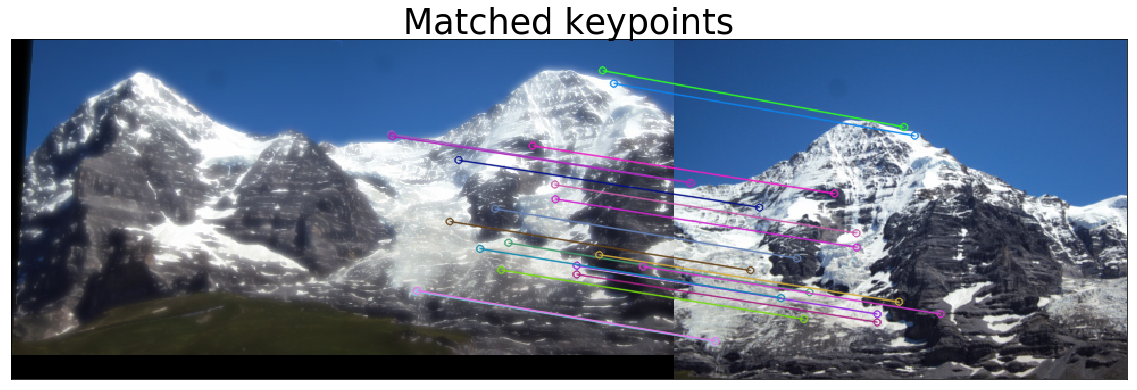

In [7]:
# create BruteForceMatcher object
BF = cv2.BFMatcher()

# Match descriptors
matches = BF.match(descriptors_l,descriptors_r)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

#Keep only the 20 best pair
bestMatches = matches[:20]

# Draw first 20 matches.
imgMatched123 = cv2.drawMatches(imgl,keypoints_l,imgr,keypoints_r, bestMatches, imgl, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(imgMatched123)
plt.title("Matched keypoints", fontsize = 35), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.3 Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.

278


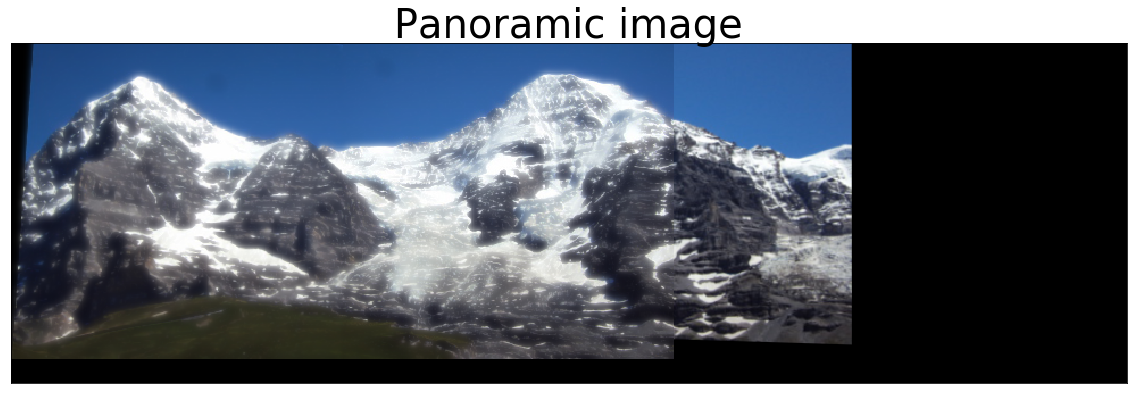

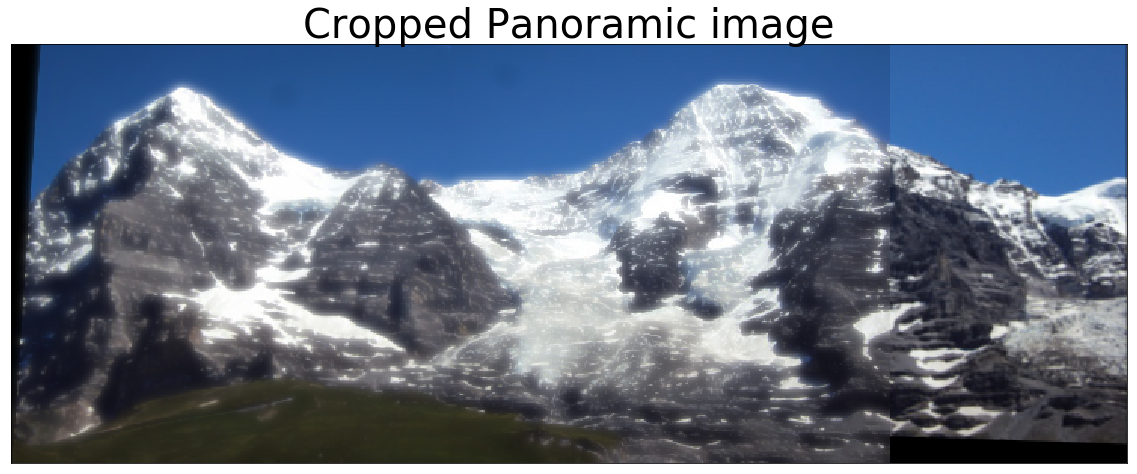

In [8]:
# Reload overwritten data
imgl = twelve_hill # set left image to Hill 12
imgr = cv2.imread('stitching_images/3Hill.jpg')[1:, 1:] # removes the border

imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints_r[i].pt for (i, __) in GoodMatches])
mpl = np.float32([keypoints_l[i].pt for (__, i) in GoodMatches])    

# Find the homography matrix and wrap image accordingly
H, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(imgr, H, (imgr.shape[1]+imgl.shape[1],imgr.shape[0]))
wimg_temp = wimg.copy()
h_diff = -(imgl.shape[0] - imgr.shape[0])

print(imgr.shape[0] - h_diff)
wimg[:imgr.shape[0] - h_diff,:imgl.shape[1],:] = imgl

plt.figure(figsize=(20,20))
plt.imshow(wimg)
plt.title("Panoramic image", fontsize = 40), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(auto_crop(wimg))
plt.title("Cropped Panoramic image", fontsize = 40), plt.xticks([]), plt.yticks([])
plt.show()

### 2.1.4 Stitch transformed 3Hill and 12Hill together and apply linear image blending.

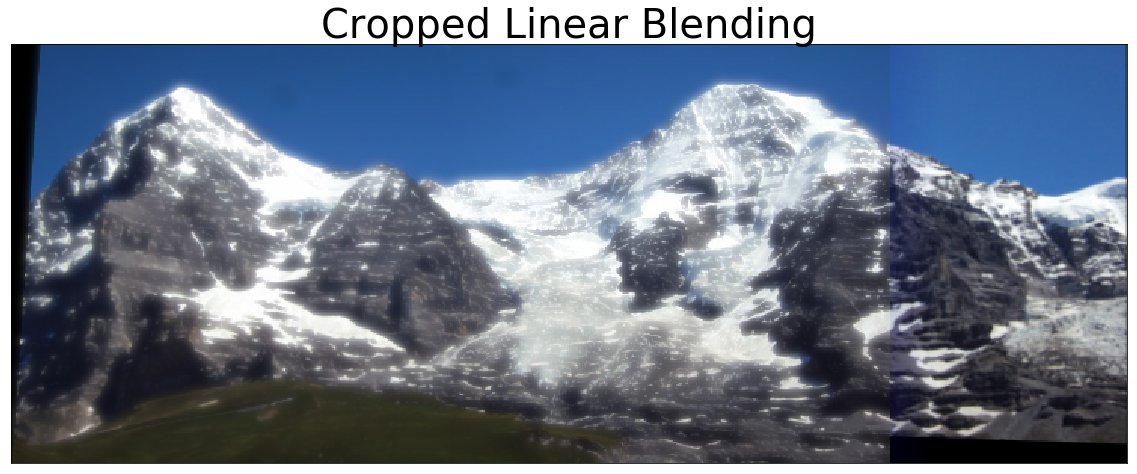

In [9]:
# Read images to stitch
A = twelve_hill.copy() # set left image to Hill 12 # set left image to Hill 12
B = auto_crop(wimg).copy()

# resize righjt image to fit 
A = cv2.copyMakeBorder(A, 0, 0, 0, (-A.shape[1] + B.shape[1]), cv2.BORDER_CONSTANT,value=150)
B = B[B.shape[0] - A.shape[0]:]

A = cv2.cvtColor(A, cv2.COLOR_BGR2RGB)

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 250  # alpha blending ramp size
alpha = Ramp(A.shape[1], ramp_size, round(A.shape[1] - ramp_size), 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * A + alpha.reshape(1,-1,1)*B
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(20,20))
#plt.imshow(auto_crop(I_blend))
plt.imshow((I_blend))
plt.title("Cropped Linear Blending", fontsize = 40), plt.xticks([]), plt.yticks([])
plt.show()

### 2.2 Reasoning Questions

In [23]:
hill_1 = cv2.imread('stitching_images/1Hill.jpg')[1:, 1:] # removes the border
hill_2 = cv2.imread('stitching_images/2Hill.jpg')[1:, 1:] # removes the border
imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

sift_obj = cv2.xfeatures2d.SIFT_create()
surf_obj = cv2.xfeatures2d.SURF_create()

t0 = time.time()
keypoints_1, descriptors_1 = sift_obj.detectAndCompute(hill_1, None)
keypoints_2, descriptors_2 = sift_obj.detectAndCompute(hill_2, None)
print("SIFT keypoints and descriptors time:", time.time() - t0)
print("Number of Hill1 and Hill2 SIFT keypoints:", len(keypoints_1), "and", len(keypoints_2))

t1 = time.time()
keypoints_1, descriptors_1 = surf_obj.detectAndCompute(hill_1, None)
keypoints_2, descriptors_2 = surf_obj.detectAndCompute(hill_2, None)
print("SURF keypoints and descriptors time:", time.time() - t1)
print("Number of Hill1 and Hill2 SURF keypoints:", len(keypoints_1), "and", len(keypoints_2))

SIFT keypoints and descriptors time: 0.11587119102478027
Number of Hill1 and Hill2 SIFT keypoints: 1258 and 1491
SURF keypoints and descriptors time: 0.11585426330566406
Number of Hill1 and Hill2 SURF keypoints: 883 and 952



#### 2.2.1 What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics.
SIFT and SURF are both methods that rely on the Hessian matrix. The key differences are that SIFT uses DoG filtering to get the value of the Hessian, whereas SURF approximates it using box filters. As we can can see from the time profiling test conducted above, SURF is slightly faster, but returns fewer keypoints. This make sense since box filtering is a faster but inferior method for getting the Hessian compared to DoG.

#### 2.2.2 Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending?
A. Linear Blending Pros: Easy to implement & and very good quality of output for correctly picked parameters
Linear Blending Cons: Choosing the parameters is not obvious and requires trial and error & this type of blending is not smooth for high frequencies.

B. Pyramid Blending Pros: Good for smoothing at any frequency & preserves sharp transitions.
Pyyramid Blending Cons: Not as easy to implement as linear blending & this method finds it hard to blend images with very different colors.

#### 2.2.3 What would happen if a random subset of pairs of matching keypoints is used for finding homography?
If we used a random number of of pairs of matching points for keypoints it would reduced the quality of our homography. The result would be that our Homographic matrix would be inaccurate and map a lot of points poorly from on image to the other.

#### 2.2.4 Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography.
An increased number of correctly matched keypoints enchances the quality of of the estimated homographic matrix H. However, if a region of the image has too many datapoints in it it can reduce the accuracy of H because it will introduce bias around that region and cause H to map points away fro that region inaccurately.